### The effect of different rheology on sea-ice breakup 

#### Author: Jonathan Rheinlænder*
#### Date: Jun. 02 2022
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

To test the impact of the BBM ice rheology formulation used in the neXtSIM simulations we performed additional experimemts with the "standard" EVP and mEVP rheologies. Aside from the rheology the experiments are identical to the standard WRF10 expt described in the manuscript. 

In [ ]:
# allow plots to be interactive in the notebook
%matplotlib inline
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path  
import sys
import xarray as xr
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
import cmocean
import argparse
import locale 
from pynextsim.projection_info import ProjectionInfo
import cmocean as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

In [ ]:
def calc_deformation_rate(uv, res, dt=24*60*60):
    '''
    Parameters:
    -----------
    uv : list
        uv = [u, v] with u, v x/y or lon/lat components of wind velocity
    res: resolution of moorings
    dt: time conversion from sec to day    
        
    '''
    
    # [1/s ==> 1/d]
    u_x, v_x = [dt*np.gradient(a, axis=1)/res for a in uv]
    u_y, v_y = [dt*np.gradient(a, axis=0)/res for a in uv]
    
    div = u_x + v_y
    shear = np.hypot(u_x - v_y, u_y + v_x)   
    deform = np.hypot(div, shear)
             
    return shear, div, deform


def prepare_grid(ds):
    
    # Get x-y grid from model
    lons = ds.longitude[:]
    lats = ds.latitude[:]
    x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
    x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
    y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
    ex_lim=1
    x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
    y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

    grid = dict(
        extent=extent,
        proj=proj,
        x_extent=x_extent,
        y_extent=y_extent,
        )

    return grid

def plot_nextsim(ax, grid, array, clevs, cmap, extend, clabel, add_colorbar=True, **kwargs):
    clevs = np.linspace(clevs[0], clevs[1], clevs[2], endpoint=True)
    
    cs = ax.contourf(array, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']],
             levels=clevs, cmap=cmap, extend=extend, **kwargs)

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, color="darkgrey")
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")
    ax.set_extent([-100, -50, 67, 87], ccrs.PlateCarree(central_longitude=300))

    # add colorbar 
    if add_colorbar:
        cax = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)

        cbar = plt.colorbar(cs, cax=cax, ticks=clevs[::10], label=clabel)
        #cbar.ax.locator_params(nbins=5)
def add_rectangle(ax, rect, **kwargs):
    from matplotlib.patches import Rectangle
    '''Adds a box in axes coordinates outlining the Beaufort Sea
    '''
    x,y,dx,dy=rect
    print(rect)
    ax.add_patch(Rectangle((x,y),dx,dy, **kwargs))
    
# Open ArcLeads
def open_Arcleads(indir, dto):
    
    dto = dt.datetime.strptime(dto,'%Y-%m-%d')
    # ArcLeads grid
    latlon_grid =  xr.open_dataset(indir + 'latlonmap.nc')

    filename = indir + 'ArcLeads_' + str(dt.datetime.strftime(dto,'%Y%m%d')) + '.nc'
    print("Loading ", filename)
    ds = xr.open_dataset(filename)     
    ds['longitude'] = latlon_grid['longitude']
    ds['latitude'] = latlon_grid['latitude']
    
    return ds

def plot_leadmap(ax, ds, add_colorbar=True, **cbargs):
    '''
    Parameters:
        ax: GeoAxes object
        ds: Xarray.dataset of Arcleads 
        add_colorbar: True or False
    '''
    
    from matplotlib.colors import ListedColormap
    
    # define colors
    col_dict={0:"darkgrey",
              1:"black",
              2:"ghostwhite",
              3:"moccasin",
              4:"mediumblue"}

    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # get colorbar tick labels 
    attr = ds.attrs['surface classes']

    labels={0:"land",
            1:"clouds",
            2:"sea ice",
            3:"artifact",
            4:"lead"}

    ## Prepare bins for the normalizer
    len_lab = len(labels)
    norm_bins = np.sort([*col_dict.keys()]) + 0.
    norm_bins = np.insert(norm_bins, 5, np.max(norm_bins) + 1.0)

    ## Make normalizer and formatter
    norm = mpl.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

    # prepare plot
    lons = ds.longitude.transpose()
    lats = ds.latitude.transpose()
    leadMap = ds.leadMap.transpose()
    
    #ax = plt.subplot(axes, projection=grid['proj'].crs, extent=grid['extent'])
    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, facecolor="darkgrey")
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")
    ax.set_extent([-100, -50, 67, 87], ccrs.PlateCarree(central_longitude=300))

    im = ax.pcolormesh(lons, lats, leadMap, transform=ccrs.PlateCarree(), cmap=cm, norm=norm)
    
    if add_colorbar:
        diff = norm_bins[1:] - norm_bins[:-1]
        tickz = norm_bins[:-1] + diff / 2
        cax = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)

        out = plt.colorbar(im, cax=cax, format=fmt, ticks=tickz)
        
def plot_sar(ax, grid, array, clevs, cmap, extend, clabel, add_colorbar=True, **kwargs):
    clevs = np.linspace(clevs[0], clevs[1], clevs[2], endpoint=True)
    
    x, y, t, e_tot = array
    
    # plot triangulated deformation
    tripcol = ax.tripcolor(x, y, t, e_tot, mask=np.isnan(e_tot), vmin=clevs[0], vmax=clevs[-1], cmap=cmap)
    
    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, color="darkgrey")
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")
#    ax.set_extent([-100, -50, 67, 87], ccrs.PlateCarree(central_longitude=300))
    ax.set_extent([-85, -60, 69, 78], ccrs.PlateCarree(central_longitude=300))

    # add colorbar 
    if add_colorbar:
        cax = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)

        cbar = plt.colorbar(tripcol, cax=cax, ticks=clevs[::10], label=clabel)

In [ ]:
# setup directories 
rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'

expts = ["expt_01_wrf10/outputs/", "expt_01_wrf10-evp/outputs-120sc/", "expt_01_wrf10-mevp/outputs-120sc/"]
expts_names = ["BBM", "EVP 120","m-EVP 120"]

# open moorings
files = [os.path.join(inpath, f, 'Moorings.nc') for f in expts]
ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])
ds2 = xr.open_dataset(files[2])
dslist = [ds0, ds1, ds2]

# Projection stuff
extent = [-110, 200, 67, 90]
proj = ProjectionInfo() # default nextsim projection
grid = prepare_grid(ds0)

In [6]:
# Load observational data 

# Load Arcleads
dto = '2013-02-25'
arcleads_dir = '/home/rheinlender/shared-simstore-ns9829k/data/ARCLEADS/'
arc = open_Arcleads(arcleads_dir, dto)

# load SAR deformation (in NSIDC projection)
# Deformation units are percent per day (%/d)
f = rootdir + '/home/rheinlender/data/RadarSat2/' + 'RS2_OK37500_PK364951_DK322250_SCWA_20130225_020811_HH_HV_SGF_deformation.npz'
x, y, t, e1, e2, e_tot, u, v = [
    np.load(f)[i] for i in ['x', 'y', 't', 'e1', 'e2', 'e_tot', 'u', 'v']]

# Convert to neXtSIM projection
x, y, _ = proj.crs.transform_points(ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70), x, y).T


Loading  /home/rheinlender/shared-simstore-ns9829k/data/ARCLEADS/ArcLeads_20130225.nc


/opt/conda/envs/pynextsim/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


[-2200000, -400000, 1000000, 900000]


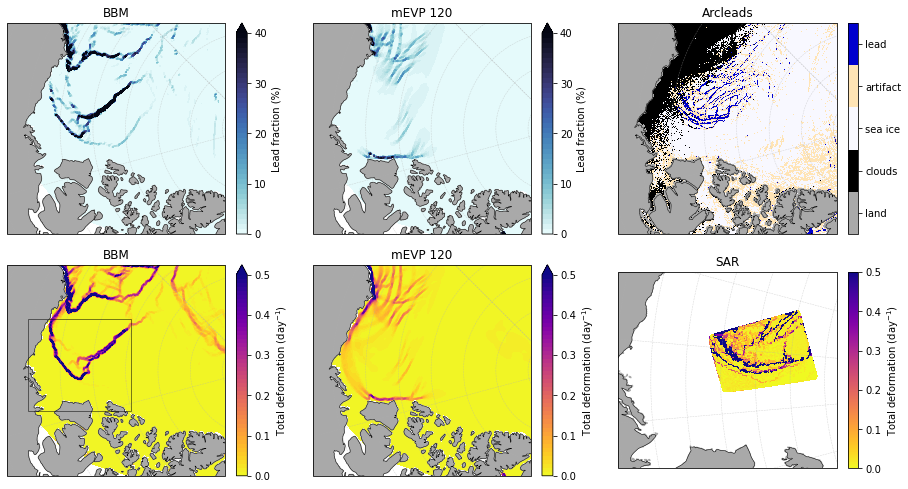

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/leadfrac_deformation_beaufort_2013-02-25_bbm_mevp120_obs.png


In [8]:
lead_plotargs = ((0,40, 41), cm.cm.ice_r, 'max', "Lead fraction (%)")
deform_plotargs = ((0,0.5, 51), 'plasma_r', 'max',"Total deformation (day$^{-1}$)")

# Make subplot   
nrow=2; ncol=3 
fig, ax = plt.subplots(nrow,ncol, figsize=(12,7),
                       subplot_kw={'projection': grid['proj'].crs, 'extent': grid['extent']})

varlist = [ds0, ds2]
for i in range(0,ncol):
    if i<=1: # nextsim
        ds_sel = varlist[i].sel(time=dto).mean(dim='time')
        
        # Compute lead fraction
        leadfrac = 1-ds_sel['sic'] + ds_sel['sic_thin']
        leadfrac = leadfrac*100 # in %
        uv = (ds_sel['siu'], ds_sel['siv'])
        shear, div, deformation = calc_deformation_rate(uv, 5000, 24*60*60)
        
        plot_nextsim(ax[0,i], grid, leadfrac, *lead_plotargs, add_colorbar=True)
        plot_nextsim(ax[1,i], grid, deformation, *deform_plotargs, add_colorbar=True)
 
    if i==2: # observations
        plot_leadmap(ax[0,i], arc, add_colorbar=True) # arcleads
        plot_sar(ax[1,i], grid, (x,y,t,e_tot*1e-2),*deform_plotargs, add_colorbar=True) # SAR

# Set titles 
for j in range(0,nrow):
    ax[j,0].set_title('BBM')
    ax[j,1].set_title('mEVP 120')
ax[0,2].set_title('Arcleads')
ax[1,2].set_title('SAR')

xmin, xmax = [-2200000, -1200000]
ymin, ymax = [-400000, 500000]
ax[1,2].set_xlim(xmin, xmax)
ax[1,2].set_ylim(ymin, ymax)

# add box
dy=ymax-ymin
dx=xmax-xmin 
rect = [xmin, ymin, dx, dy]
add_rectangle(ax[1,0], rect, fill=None, alpha=0.5, zorder=2)

fig.subplots_adjust(bottom=0.01, top=0.96, left=0.02, right=0.98, wspace=0.4, hspace=0.02)
plt.show()

# save figure
figname = os.path.join(outpath_plots,
      '%s%s_%s_%s' % (outpath_plots, 'leadfrac_deformation_beaufort', dto ,'bbm_mevp120_obs.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight') 

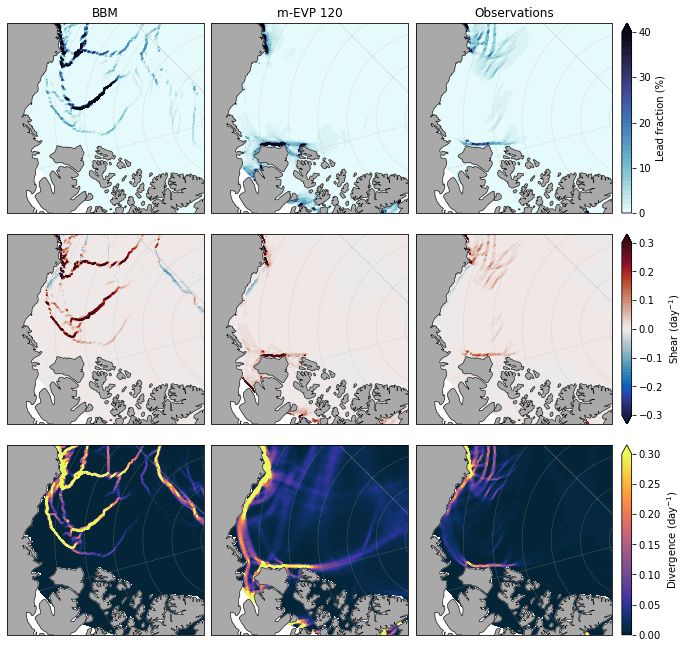

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/leadfrac_deformation_beaufort_2013-02-24_bbm_evp120_mevp120.png


In [9]:
lead_plotargs = ((0,40, 41), cm.cm.ice_r, 'max', "Lead fraction (%)")
shear_plotargs = ((0,0.30, 61), cm.cm.thermal, 'max', "Divergence (day$^{-1}$)")
div_plotargs = ((-0.3,0.3, 61), cm.cm.balance, 'both',"Shear (day$^{-1}$)")
deform_plotargs = ((0,0.5, 51), 'plasma_r', 'max',"Total deformation (day$^{-1}$)")

#lead_plotargs = ((0,40, 41), cm.cm.ice_r, 'max')
#shear_plotargs = ((0,0.50, 51), cm.cm.thermal, 'max')
#div_plotargs = ((-0.52,0.52, 53), cm.cm.balance, 'both')

# Make subplot    
fig, ax = plt.subplots(3,3, figsize=(10,9),
                       subplot_kw={'projection': grid['proj'].crs, 'extent': grid['extent']})
t2 = '2013-02-24'

expts_names = ["BBM", "m-EVP 120", "Observations"]
for i, ds in enumerate(dslist):

    ds_sel = ds.sel(time = t2).mean(dim='time')
    
    # Compute lead fraction
    leadfrac = 1-ds_sel['sic'] + ds_sel['sic_thin']
    leadfrac = leadfrac*100 # in %
    
    uv = (ds_sel['siu'], ds_sel['siv'])
    shear, div, deformation = calc_deformation_rate(uv, 5000, 24*60*60)
    
    if i==2:
        plot_nextsim(ax[0,i], grid, leadfrac, *lead_plotargs, add_colorbar=True)
        plot_nextsim(ax[1,i], grid, div, *div_plotargs, add_colorbar=True)
        plot_nextsim(ax[2,i], grid, shear, *shear_plotargs, add_colorbar=True)

    else:
        plot_nextsim(ax[0,i], grid, leadfrac, *lead_plotargs, add_colorbar=False)
        plot_nextsim(ax[1,i], grid, div, *div_plotargs, add_colorbar=False)
        plot_nextsim(ax[2,i], grid, shear, *shear_plotargs, add_colorbar=False)
    
    # set titles
    #datestr = dt.datetime.strftime(dto, "%Y-%m-%d")
    ax[0,i].set_title(expts_names[i])   

fig.subplots_adjust(bottom=0.01, top=0.98, left=0.02, right=0.86, wspace=0.04, hspace=0.02)
plt.show()

# save figure
figname = os.path.join(outpath_plots,
      '%s%s_%s_%s' % (outpath_plots, 'leadfrac_deformation_beaufort', t2 ,'bbm_evp120_mevp120.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight') 

Note that the deformation rates are relatively high, compared to normal values (in the range 0.1 day$^{-1}$). 
The high deformation rates arrise from the highly localized fracturing and lead openings, which in some instances are more that 10 km wide.  

# Check mEVP for 120, 500 and 900 subcycles

In [ ]:
# deformation for mevp 120, 500 amd 900 substeps

expts = ["expt_01_wrf10-mevp/outputs-120sc/", "expt_01_wrf10-mevp/outputs-500sc/" ,"expt_01_wrf10-mevp/outputs-900sc/"]
expts_names = ["mEVP 120", "mEVP 500","mEVP 900"]

files = [os.path.join(inpath, f, 'Moorings.nc') for f in expts]

ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])
ds2 = xr.open_dataset(files[2])
dslist = [ds0, ds1, ds2]

t2 = '2013-02-25'
#args={'add_colorbar':True}
lead_plotargs = ((0,40, 41), cm.cm.ice_r, 'max', "Lead fraction (%)")
shear_plotargs = ((0,0.30, 61), cm.cm.thermal, 'max', "Divergence (day$^{-1}$)")
div_plotargs = ((-0.3,0.3, 61), cm.cm.balance, 'both',"Shear (day$^{-1}$)")

for i, fl in enumerate(files):
    print('opening', fl)
    ds = xr.open_dataset(fl)

    ds_sel = ds.sel(time = t2).mean(dim='time')
    
    # Compute lead fraction
    leadfrac = 1-ds_sel['sic'] + ds_sel['sic_thin']
    leadfrac = leadfrac*100 # in %
    
    uv = (ds_sel['siu'], ds_sel['siv'])
    shear, div, deformation = calc_deformation_rate(uv, 5000, 24*60*60)
    
    # Make subplot    
    fig, ax = plt.subplots(1,3, figsize=(10,8),
                       subplot_kw={'projection': grid['proj'].crs, 'extent': grid['extent']})
    plot_nextsim(ax[0], grid, leadfrac, *lead_plotargs, add_colorbar=True)
    plot_nextsim(ax[1], grid, div, *div_plotargs)
    plot_nextsim(ax[2], grid, shear, *shear_plotargs)
    
    ax[1].set_title(expts_names[i])
    
    fig.subplots_adjust(bottom=0.01, top=0.96, left=0.02, right=0.98, wspace=0.4, hspace=0.08)
    plt.show()


    #save figure
    
    figname = '%s%s_%s_%s.%s' % (outpath_plots, 'leadfrac_div_shear_beaufort', 
                                 t2.replace('-',''), expts_names[i].replace(" ", ""), 'png')
    print("saving ", figname)
    fig.savefig(figname, dpi=300, bbox_inches='tight')    
    

# Plot lead fraction and ice velocity during the breakup

In [ ]:
plt.close('all')

# Make subplot    
fig, ax = plt.subplots(2,3, figsize=(10,6),
                       subplot_kw={'projection': grid['proj'].crs, 'extent': grid['extent']})

t1 = '2013-02-18'
t2 = '2013-03-01'

clevs = np.arange(0, 25+1, 1) 
cbargs0 = {"label": "Lead fraction [%]", "extend": "max"}
cbargs1 = {"label": "Ice velocity [cm/s]", "extend": "max"}

expts_names = ["BBM", "EVP 120","m-EVP 120"]
for i, ds in enumerate(dslist):

    # Compute lead fraction
    leadfrac = 1-ds['sic'] + ds['sic_thin']
    leadfrac = leadfrac.sel(time=slice(t1, t2)).mean(axis=0)*100 # in %
    
    # calculate ice velocity 
    ds['icevel'] = (ds['siu']**2 + ds['siv']**2)**0.5
    icevel = ds['icevel'].sel(time=slice(t1, t2)).mean(axis=0)*100 # in cm/s
      
    if i==2:
        plot_nextsim(ax[0,i], grid, leadfrac, np.arange(0, 40, 5) , cm.cm.ice_r, add_colorbar=True, **cbargs0)
        plot_nextsim(ax[1,i], grid, icevel, clevs, cm.cm.speed, add_colorbar=True, **cbargs1)
    else:
        plot_nextsim(ax[0,i], grid, leadfrac, np.arange(0, 40, 5) , cm.cm.ice_r, add_colorbar=False, **cbargs0)
        plot_nextsim(ax[1,i], grid, icevel, clevs, cm.cm.speed, add_colorbar=False, **cbargs1)

    # set titles
    datestr = dt.datetime.strftime(dto, "%Y-%m-%d")
    ax[0,i].set_title(expts_names[i])   


fig.subplots_adjust(bottom=0.01, top=0.96, left=0.02, right=0.86, wspace=0.04, hspace=0.08)
plt.show()

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s-%s_%s' % (outpath_plots, 'leadfrac_icevel_beaufort', t1, t2 ,'bbm_evp120_mevp120.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')  

When using the elastic-visco-plastic models the simulated velocity field is smoother compared to the BBM model and does not reproduce the observed fracturing.    

With BBM the ice cover consists of seperate ice floes that move at different speeds reletive to one-another. Small scale deformation features are also better resolved. 

Note that the resolution of the sea-ice model (and atm. forcing) is the same for all experiments. 
